# Turbo Engine data description

CMAPSS stands for Commercial Modular Aero-Propulsion System Simulation. It is a system developed by NASA to study engine degradation. It is coded in MATLAB and Simulink (A toolbox of MATLAB). 

The engine under study is a turbofan engine (a jet engine). A turbofan engine has many components. A few important components are: Fan, Low Pressure Compressor (LPC), High Pressure Compressor (HPC), Low Pressure Turbine (LPT), High Pressure Turbine (HPT). 

During operation, degradation occurs in each of the components. If degradation level in any component exceeds a threshold, the engine is said to have failed. We don't want jet engines to fail mid-air. Therefore, jet engines are inspected before every take off. This is a form of periodic maintenance that is not cost effective. 

But given the critical nature of operation (considering human lives involved), this form of maintenance strategy is justified. Even then, we need a system that can given us early warning if something is going to fail. 

An early warning, in many cases, may help us prepare for the problem, if not prevent it altogether. A sufficiently early warning will enable us to prevent the disaster. But if an early warning is too conservative, it will lead to unnecessary waste of money. So, aim of a predictive maintenance system is to predict the RUL as accurately as possible such that it is neither too early nor too late. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

In [5]:
raw_data = pd.read_csv('train_FD001.txt', sep=' ', header = None)
raw_data

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,NaN,NaN
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,NaN,NaN
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,NaN,NaN
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,NaN,NaN


In [6]:
raw_data = raw_data.drop([26,27], axis='columns')

* `Column 1`: Corresponds to engine number (This column is indexed 0 above because of Python's numbering convention)
* `Column 2`: Corresponds to cycle number. If engine 1 fails after 192 cycles, the entries of second column for engine 1 will go from 1 to 192. Similarly for other engines. 
* `Columns 3,4,5`: 3 operational settings
* `Columns 6-26`: 21 sensor measurements

In [7]:
raw_data.columns = ['ID', 'Cycle', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure1', 'SensorMeasure2', 'SensorMeasure3', 'SensorMeasure4', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure7', 'SensorMeasure8', 'SensorMeasure9', 'SensorMeasure10', 'SensorMeasure11', 'SensorMeasure12', 'SensorMeasure13', 'SensorMeasure14', 'SensorMeasure15', 'SensorMeasure16', 'SensorMeasure17', 'SensorMeasure18', 'SensorMeasure19', 'SensorMeasure20', 'SensorMeasure21']
raw_data

,ID,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [19]:
raw_data[raw_data['ID'] == 1]

,ID,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1,188,-0.0067,0.0003,100.0,518.67,643.75,1602.38,1422.78,14.62,...,519.79,2388.23,8117.69,8.5207,0.03,396,2388,100.0,38.51,22.9588
188,1,189,-0.0006,0.0002,100.0,518.67,644.18,1596.17,1428.01,14.62,...,519.58,2388.33,8117.51,8.5183,0.03,395,2388,100.0,38.48,23.1127
189,1,190,-0.0027,0.0001,100.0,518.67,643.64,1599.22,1425.95,14.62,...,520.04,2388.35,8112.58,8.5223,0.03,398,2388,100.0,38.49,23.0675
190,1,191,-0.0000,-0.0004,100.0,518.67,643.34,1602.36,1425.77,14.62,...,519.57,2388.30,8114.61,8.5174,0.03,394,2388,100.0,38.45,23.1295


In [15]:
# Making an array which contains EOL of all the Ids
EOL=[]
for sl_no in raw_data['ID']:
        EOL.append( ((raw_data[raw_data['ID'] == sl_no]["Cycle"]).values)[-1])

In [23]:
np.shape(EOL)

(20631,)

In [24]:
# Append the "EOL" column
raw_data["EOL"]=EOL

In [25]:
raw_data

,ID,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21,EOL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,192
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,192
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,200
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,200
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,200
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,200


<h2>Classification Problem Formulation</h2>

The challange of this competetion was to predict the Remaining Useful Life of the engine by using the given sensor's data and operational conditions. 

But in this project, we ll try to simplify that by converting it to a Classification Problem. Where, the classes/labels will of 3 types, i.e. **Good Condition, Moderate Condition and Warning Condition**.

<h4>labels corresponding to each conditions</h4>

- Good Condition -     0
- Moderate Condition - 1
- Warning Condition -  2

<h2>Defining the labels</h2>

Here we will define the engine's condition with **Life Ratio (LR)**, which is the ratio between **Current Cycle** and the **End cycle/ End of Life(EOL)**. If **LR=0**, that means the component has just started its degradation and **LR=1** means, it is completely degraded.

- if LR <= 0.6 -       Good Condition
- if 0.6 < LR <= 0.8 - Moderate Condition
- if 0.8 < LR -        Warning Condition

In [26]:
# Calculate "LR"
raw_data["LR"] = raw_data["Cycle"].div(raw_data["EOL"])

In [27]:
raw_data

,ID,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21,EOL,LR
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192,0.005208
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192,0.010417
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,192,0.015625
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,192,0.020833
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,192,0.026042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,200,0.980000
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,200,0.985000
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,200,0.990000
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,200,0.995000


In [28]:
# Drop ID and EOL
raw_data=raw_data.drop(columns=['ID','EOL'])

In [29]:
labels=[]
for i in range (0,len(raw_data)):
    if np.array(raw_data["LR"])[i] <= 0.6:
        labels.append(0)
    elif np.array(raw_data["LR"])[i] <= 0.8 :
        labels.append(1)   
    else :
        labels.append(2)  
        
raw_data["labels"]=labels
raw_data  = raw_data.drop(columns=['LR'])   
raw_data

,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,SensorMeasure6,...,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21,labels
0,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,0
1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,0
2,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,0
3,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,0
4,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,2
20627,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,2
20628,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,21.61,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,2


<h2>Making Training Data-set</h2>

Now the classification data-set is all set, with **25** Features and **1** label/class column, containing 3 classes.

It can be saved in a **.csv** file to access it in any other notebook. Similarly all the **4** Training data were converted into this format and saved as **.csv** file.

In [ ]:
#raw_data.to_csv('Training_1_all_features.csv', index=None)

<h2>Importing all the Training Data-sets</h2>

In [30]:
df1 = pd.read_csv('Training_1_all_features.csv')
df2 = pd.read_csv('Training_2_all_features.csv')
df3 = pd.read_csv('Training_3_all_features.csv')
df4 = pd.read_csv('Training_4_all_features.csv')

In [31]:
df = pd.concat([df1,df2,df3,df4])

In [32]:
df

,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,SensorMeasure6,...,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21,labels
0,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,0
1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,0
2,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,0
3,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,0
4,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61244,251,9.9998,0.2500,100.0,489.05,605.33,1516.36,1315.28,10.52,15.46,...,2388.73,8185.69,8.4541,0.03,372,2319,100.0,29.11,17.5234,2
61245,252,0.0028,0.0015,100.0,518.67,643.42,1598.92,1426.77,14.62,21.57,...,2388.46,8185.47,8.2221,0.03,396,2388,100.0,39.38,23.7151,2
61246,253,0.0029,0.0000,100.0,518.67,643.68,1607.72,1430.56,14.62,21.57,...,2388.48,8193.94,8.2525,0.03,395,2388,100.0,39.78,23.8270,2
61247,254,35.0046,0.8400,100.0,449.44,555.77,1381.29,1148.18,5.48,7.96,...,2388.83,8125.64,9.0515,0.02,337,2223,100.0,15.26,9.0774,2


**X** is the Feature Matrix and **y** is the label's column

In [33]:
X = df.iloc[:,0:-1]
y = df.iloc[:,-1]

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 0)

<h2>Training a Random Forest model</h2>

In [35]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier()
RF.fit(X_train, y_train)

RandomForestClassifier()

<h2>Performance on Validation set<h2>

0.8933649289099526

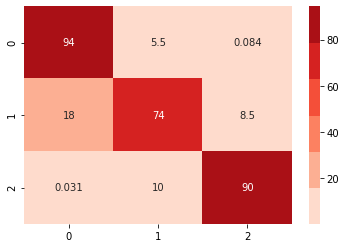

In [36]:
y_pred_RF = RF.predict(X_test)

cm = pd.DataFrame(confusion_matrix(y_test, y_pred_RF, normalize ='true')*100)
colormap = sns.color_palette("Reds")
sns.heatmap(cm, annot=True,cmap=colormap)

accuracy_score(y_test, y_pred_RF)

In [37]:
RF.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

<h2> Performance on Training set<h2>

0.9999930710974688

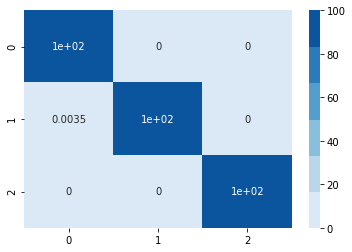

In [38]:
y_pred_RF = RF.predict(X_train)

cm = pd.DataFrame(confusion_matrix(y_train, y_pred_RF, normalize ='true')*100)
colormap = sns.color_palette("Blues")
sns.heatmap(cm, annot=True,cmap=colormap)

accuracy_score(y_train, y_pred_RF) # or RF.score(X_train,y_train)

## Randomized Search with cross validation for Hyperparameter optimization
    
As the previous model clearly overfits the training data, we need to do some hyperparameter tuning. For that we will do a random search with 3 fold cross validation

In [40]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators=[200, 400, 300]
# Maximum number of levels in tree
max_depth= [10, 20, 30]
# Max number of samples given to each tree 
max_samples= [0.2,0.3,0.4 ]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'max_samples': max_samples}
print(random_grid)

{'n_estimators': [200, 400, 300], 'max_depth': [10, 20, 30], 'max_samples': [0.2, 0.3, 0.4]}


In [41]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = 3,n_jobs=-1)
# Fit the random search model
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30],
                                        'max_samples': [0.2, 0.3, 0.4],
                                        'n_estimators': [200, 400, 300]})

In [46]:
rf_random.best_params_

{'n_estimators': 300, 'max_samples': 0.4, 'max_depth': 20}

In [47]:
rf_random.best_score_

0.889726507996794

0.8938014467448241

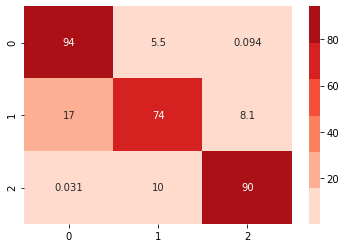

In [48]:
RF_randSer = RandomForestClassifier(n_estimators=300,max_samples=0.4,max_depth= 20)
RF_randSer.fit(X_train, y_train)
y_pred_RF = RF_randSer.predict(X_test)

cm = pd.DataFrame(confusion_matrix(y_test, y_pred_RF, normalize ='true')*100)
colormap = sns.color_palette("Reds")
sns.heatmap(cm, annot=True,cmap=colormap)

accuracy_score(y_test, y_pred_RF)

# Testing on given Test-Dataset

In [49]:
df1 = pd.read_csv('Test_classification_1.csv')
df2 = pd.read_csv('Test_classification_2.csv')
df3 = pd.read_csv('Test_classification_3.csv')
df4 = pd.read_csv('Test_classification_4.csv')

test_df = pd.concat([df1,df2,df3,df4])

X_test = test_df.iloc[:,0:-1]
y_test = test_df.iloc[:,-1]

0.9068133502388057

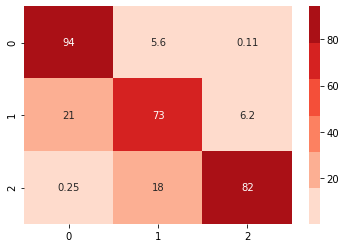

In [50]:
y_pred_RF = RF_randSer.predict(X_test)

cm = pd.DataFrame(confusion_matrix(y_test, y_pred_RF, normalize ='true')*100)
colormap = sns.color_palette("Reds")
sns.heatmap(cm, annot=True,cmap=colormap)

accuracy_score(y_test, y_pred_RF)